# Introduction

In this notebook, I will develop a system for forecasting influenza viral evolution. More specifically, I would like to predict the probability distribution over new influenza sequences, given current sequences.

## Use Case

This data product uses my background knowledge of influenza evolution and marries it with recent skills picked up in deep learning to try to forecast future influenza sequences. This is potentially a long-term competitive advantage for a company building out vaccines against fast-evolving viruses, and more generally, a long-term competitive advantage for public health.

Borrowing a quote from one of the great ice hockey players,

> I skate to where the puck will be, not where it has already been. (Wayne Gretzky)

## Data

The data come from the [influenza research database ](https://www.fludb.org/)(IRD). Search parameters were as follows:

- Data Type: Protein
- Virus Type: A
- Subtype: H3N2
- Date Range: From 2000
- 'Classical' Proteins: Complete? HA

No other search parameters were used. Data were downloaded on 31 May 2017.

## Learning Strategy

1. Use variational autoencoders, a deep learning method, to learn a latent manifold on which sequence evolution is taking place. 
1. Simultaneously construct a genotype network of flu evolution.
    1. Nodes: Influenza HA protein sequences.
    1. Edges: Sequences differ by one amino acid.
1. Sanity checks:
    1. Plot edit distance between any two random pairs of protein sequences against their manifold distance. There should be a linear relationship between the two.
1. Validation:
    1. MVP validation will be done by doing one round of "back testing" - we 
    
    
## Technical aspects demonstrated

1. Deep learning.
1. Basic time series analysis.
1. Genomics.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import networkx as nx
import tensorflow as tf
import pymc3 as pm

plt.style.use('fivethirtyeight')


from Bio import SeqIO
from copy import deepcopy
from datetime import datetime
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.callbacks import EarlyStopping
from Levenshtein import distance as levD
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from scipy.spatial import ConvexHull
from scipy.spatial.distance import euclidean as eucD

from custom import load_sequence_and_metadata, encode_array, save_model

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first will start with doing some basic cleaning of the data.

1. We want to make sure that there's only human flu sequences. The dataset may contain non-flu sequences.
1. We want to forecast 2017 sequences. Therefore, any machine learning fitting can only be done on the data up to 2016; any predictions are to be done on 2017 sequences.

In [3]:
# Let's start by loading the protein sequence FASTA file and metadata.
sequences, metadata = load_sequence_and_metadata()
assert len(sequences) == len(metadata)

# Filter for just human sequences, then split into training and test set.
metadata = metadata[metadata['Host Species'] == 'IRD:Human']
training_metadata = metadata[metadata['Collection Date'] < datetime(2017, 1, 1)]
training_idxs = [i for i, s in enumerate(sequences) if s.id in training_metadata['Sequence Accession'].values]

test_metadata = metadata[metadata['Collection Date'] >= datetime(2017, 1, 1)]
test_idxs = [i for i, s in enumerate(sequences) if s.id in test_metadata['Sequence Accession'].values]

# Encode as array.
sequence_array = encode_array(sequences)
training_array = sequence_array[training_idxs]
test_array = sequence_array[test_idxs]

training_sequences = [sequences[i] for i in training_idxs]
test_sequences = [sequences[i] for i in test_idxs]

In [4]:
# Sanity checks
assert len(training_array) == len(training_metadata)
assert len(test_array) == len(test_metadata)

Let's now build the variational autoencoder model. This is a deep learning model that provides us with a way to learn a latent representation of discrete sequence space as a continuous representation instead. It's both a visualization tool and a deep learning data compression tool.

In [5]:
# Set up VAE.
with tf.device('/gpu:0'):
    intermediate_dim = 1000
    encoding_dim = 3
    latent_dim = encoding_dim
    epsilon_std = 1.0
    nb_epoch = 250

    x = Input(shape=(training_array.shape[1],))
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)

    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(latent_dim, ), mean=0.,
                                  stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    def vae_loss(x, x_decoded_mean):
        xent_loss = training_array.shape[1] * objectives.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return xent_loss + kl_loss

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
    x_decoded_mean = Dense(training_array.shape[1], activation='sigmoid')(z_mean)

    vae = Model(x, x_decoded_mean)
    vae.compile(optimizer='adam', loss=vae_loss)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    encoder_var = Model(x, z_log_var)

    x_train, x_test = train_test_split(training_array)

    early_stopping = EarlyStopping(monitor="val_loss", patience=2)


    # build the decoder
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = vae.layers[-1]
    # create the decoder model
    decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))


    # Train the VAE to learn weights
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=nb_epoch,
            validation_data=(x_test, x_test),
            callbacks=[early_stopping],
           )

Train on 10029 samples, validate on 3344 samples
Epoch 1/250
10029/10029 [==============================] - 6s - loss: 1424.9897 - val_loss: 507.7818
Epoch 2/250
10029/10029 [==============================] - 6s - loss: 408.5319 - val_loss: 341.5093
Epoch 3/250
10029/10029 [==============================] - 6s - loss: 301.4134 - val_loss: 274.1217
Epoch 4/250
10029/10029 [==============================] - 6s - loss: 248.7987 - val_loss: 232.6467
Epoch 5/250
10029/10029 [==============================] - 6s - loss: 215.6480 - val_loss: 204.7815
Epoch 6/250
10029/10029 [==============================] - 6s - loss: 192.1552 - val_loss: 183.6856
Epoch 7/250
10029/10029 [==============================] - 6s - loss: 172.5584 - val_loss: 165.1364
Epoch 8/250
10029/10029 [==============================] - 6s - loss: 153.1815 - val_loss: 148.9316
Epoch 9/250
10029/10029 [==============================] - 6s - loss: 138.4633 - val_loss: 134.5537
Epoch 10/250
10029/10029 [========================

# Putting VAEs into Production

How might we put the VAE into production? Keras allows us to save and load models as `.h5` and `.json` files. (Reference [here](http://machinelearningmastery.com/save-load-keras-deep-learning-models/).)

I will save the model as it is right now under the `trained_models/` directory.

In [7]:
save_model(vae, 'trained_models/vae')
save_model(encoder, 'trained_models/encoder')
save_model(decoder, 'trained_models/decoder')

In [8]:
training_embeddings_mean = encoder.predict(training_array)
training_embeddings_mean.shape

(13373, 3)

Let's compute the convex hull of the `test_embedding` points, so that it can be laid over the `training_embedding` points.

In [9]:
test_embeddings_mean = encoder.predict(test_array)
test_embeddings_hull = ConvexHull(test_embeddings_mean)

In [91]:
def get_density_interval(percentage, array, axis=0):
    """
    Returns the highest density interval on the array.
    
    Parameters:
    ===========
    percentage: (float, int) value between 0 and 100, inclusive.
    array: a numpy array of numbers.
    """
    low = (100 - percentage) / 2
    high = (100 - low)
    
    lowp, highp = np.percentile(array, [low, high], axis=axis)

    
    return lowp, highp

lowp, highp = get_density_interval(97.5, training_embeddings_mean, axis=0)
lowp, highp

(array([-4.16622114, -1.230159  , -4.31266117]),
 array([ 0.59139371,  3.68226099,  0.62445158]))

Let's visualize the latent space, which is currently encoded in 3 dimensions.

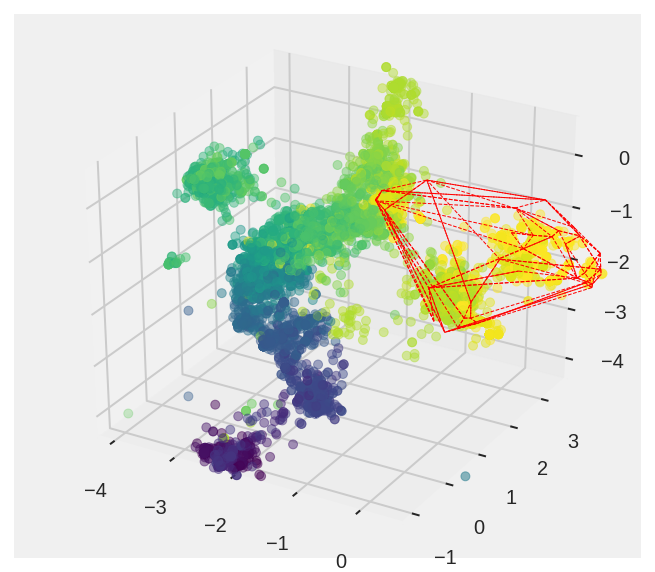

In [101]:
def 
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(training_embeddings_mean[:, 0], training_embeddings_mean[:, 1], training_embeddings_mean[:, 2], 
           c=training_metadata['Collection Date'], cmap='viridis')
for simplex in test_embeddings_hull.simplices:
    ax.plot(test_embeddings_mean[simplex, 0], 
            test_embeddings_mean[simplex, 1], 
            test_embeddings_mean[simplex, 2], 'r--', lw=0.5)
ax.set_xlim(lowp[0], highp[0])
ax.set_ylim(lowp[1], highp[1])
ax.set_zlim(lowp[2], highp[2])
plt.show()

# Sanity Check 1: Distances

I want to do a sanity check on the protein sequences. The goal here is to figure out whether short embedding euclidean distances roughly equals to short Levenshtein distances between sequences. I will sample 1000 pairs of sequences, compute their Levenshtein distance and their euclidean distances, and check that there is a linear relationship between the two.

In [11]:
# Generate pairs of random indices.
indices = np.random.randint(low=0, high=len(training_array), size=(1000, 2))
indices

array([[13053,  5674],
       [ 9122, 10873],
       [ 3001,  4760],
       ..., 
       [ 7141, 11149],
       [11137, 12939],
       [ 1638,  5035]])

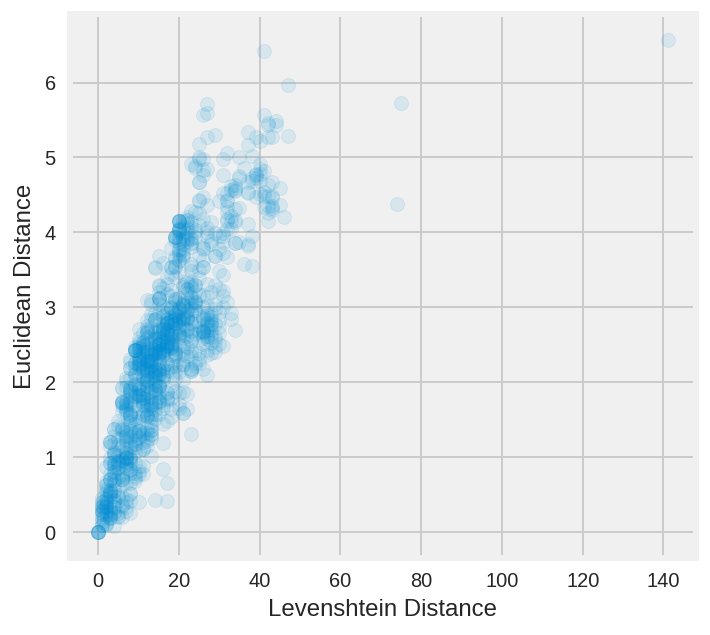

In [96]:
lev_dists = []
euc_dists = []
for i1, i2 in indices:
    lev_dist = levD(str(training_sequences[i1].seq), str(training_sequences[i2].seq))
    euc_dist = eucD(training_embeddings_mean[i1], training_embeddings_mean[i2])
    
    lev_dists.append(lev_dist)
    euc_dists.append(euc_dist)
    
fig = plt.figure(figsize=(5,5))
plt.scatter(lev_dists, euc_dists, alpha=0.1)
plt.xlabel('Levenshtein Distance')
plt.ylabel('Euclidean Distance')

## Sanity Check Conclusion
Regardless of what indices are sampled, we will generally get back a linear relationship between Euclidean and Levenshtein distances. I feel good about this sanity check.

## Visualize Evolutionary Trajectory over Time

I'm now going to try visualizing the evolutionary trajectory of the HA protein, day-by-day. We will take the average coordinate per day, and plot them in 3D space.

In [103]:
from ipywidgets import interact
from ipywidgets.widgets import Dropdown

tm_coords = deepcopy(training_metadata)  # tm_coords means "training metadata with coordinates"
tm_coords['coord0'] = training_embeddings_mean[:, 0]
tm_coords['coord1'] = training_embeddings_mean[:, 1]
tm_coords['coord2'] = training_embeddings_mean[:, 2]
avg_coords_by_day = tm_coords.groupby('Collection Date')[['coord0', 'coord1', 'coord2']].mean().dropna()
avg_coords_by_quarter = tm_coords.groupby('Collection Date')[['coord0', 'coord1', 'coord2']].mean().resample("Q").mean().dropna()

@interact(elev=(-180, 180, 10), azim=(0, 360, 10))
def plot_daily_avg(elev, azim):

    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1, projection='3d')
    ax1.scatter(avg_coords_by_day['coord0'], avg_coords_by_day['coord1'], avg_coords_by_day['coord2'],
               c=avg_coords_by_day.index, cmap='viridis')
    ax1.view_init(elev, azim)
    ax1.set_title('by day')
    
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.scatter(xs=avg_coords_by_quarter['coord0'], ys=avg_coords_by_quarter['coord1'], 
               zs=avg_coords_by_quarter['coord2'], c=avg_coords_by_quarter.index, 
               cmap='viridis')
    ax2.view_init(elev=elev, azim=azim)
    ax2.set_title('by quarter')
    
    ax1.set_xlim(ax2.get_xlim())
    ax1.set_ylim(ax2.get_ylim())
    ax1.set_zlim(ax2.get_zlim())
    
    for simplex in test_embeddings_hull.simplices:
        ax1.plot(test_embeddings_mean[simplex, 0], 
                 test_embeddings_mean[simplex, 1], 
                 test_embeddings_mean[simplex, 2], 'k-', lw=0.5)

    plt.show()


Looking at the data, it looks most feasible to try predicting coordinates for the coming **months**, particularly trying to go out 3-6 months.

Let's transform the 3D plots into three 1D plots. (This is just a viz aid.)

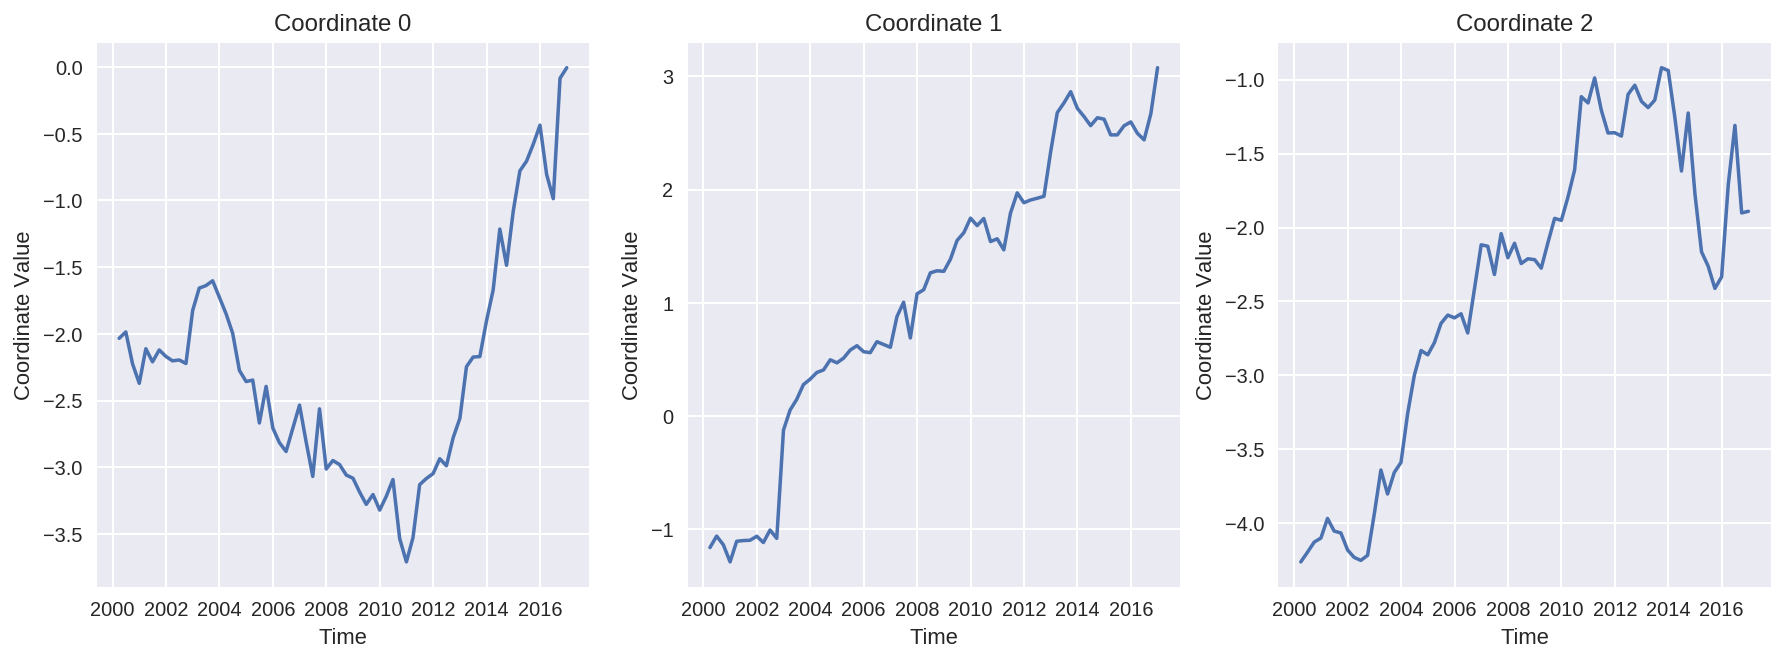

In [21]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.plot(avg_coords_by_quarter['coord0'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Coordinate Value')
ax1.set_title('Coordinate 0')

ax2 = fig.add_subplot(1,3,2)
ax2.plot(avg_coords_by_quarter['coord1'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Coordinate Value')
ax2.set_title('Coordinate 1')

ax3 = fig.add_subplot(1,3,3)
ax3.plot(avg_coords_by_quarter['coord2'])
ax3.set_xlabel('Time')
ax3.set_ylabel('Coordinate Value')
ax3.set_title('Coordinate 2')
plt.show()

# GP for Timeseries

Here's me trying out GPs... This is 

In [58]:
avg_coords_by_quarter['coord0'].values

array([-2.03348899, -1.98554432, -2.22441959, -2.37076044, -2.11132073,
       -2.20984054, -2.1208353 , -2.16957092, -2.20239449, -2.19569206,
       -2.22217679, -1.82429254, -1.65680301, -1.63820243, -1.60198843,
       -1.72524548, -1.84837949, -1.99588394, -2.27415442, -2.35748577,
       -2.3462882 , -2.66812181, -2.39381838, -2.70606923, -2.81595826,
       -2.88181829, -2.53406596, -2.8090632 , -3.06896067, -2.56205344,
       -3.01324344, -2.94958878, -2.97974944, -3.05851364, -3.08258724,
       -3.18582678, -3.27826428, -3.20452428, -3.32117319, -3.21765614,
       -3.09189129, -3.53512073, -3.70957685, -3.52783895, -3.13086987,
       -3.0842514 , -3.04734468, -2.93594217, -2.98889184, -2.77882028,
       -2.63316464, -2.2459209 , -2.17407298, -2.17019701, -1.89937794,
       -1.6708945 , -1.2140882 , -1.48588598, -1.07871926, -0.77837503,
       -0.70537823, -0.57846588, -0.43517828, -0.80435938, -0.98689932,
       -0.0838327 , -0.0044907 ], dtype=float32)

67

67

In [65]:
import theano.tensor as tt
with pm.Model() as model:
    l = pm.Uniform('l', 0, 100)
    
    # Covariance function
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=3, lengthscales=l)
    
    # Sigma
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))
    
    y_obs = pm.gp.GP('y_obs', cov_func=f_cov, sigma=s2_n, 
                     observed={'X':range(len(avg_coords_by_quarter['coord1'].values)), 
                               'Y':avg_coords_by_quarter['coord1'].values})

IndexError: list assignment index out of range